## Probability maps animation

This notebook creates an animation showing the evolution of the predicted time-dependent deposit probability for the SVM model from 170Ma-present. The notebook `02a-create_probability_maps_svm.ipynb` must have been run previously.

In [1]:
use_extracted_data = False

In [2]:
import glob
import os
import tempfile

import cartopy.crs as ccrs
import pandas as pd
from gplately import (
    PlateReconstruction,
    PlotTopologies,
)
from joblib import Parallel, delayed
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

from lib.check_files import (
    check_plate_model,
    check_prepared_data,
)
from lib.visualisation import plot

# Suppress occasional joblib warnings
%env PYTHONWARNINGS=ignore::UserWarning

env: PYTHONWARNINGS=ignore::UserWarning


In [3]:
n_jobs = 8

### Load plate model files

In [4]:
model_dir = "plate_model"
check_plate_model(model_dir, verbose=True)
feature_filenames = glob.glob(
    os.path.join(
        model_dir,
        r"*.gpml",
    )
)
rotation_filenames = glob.glob(
    os.path.join(
        model_dir,
        r"*.rot",
    )
)
coastlines_filename = os.path.join(
    model_dir,
    "StaticGeometries",
    "AgeGridInput",
    "CombinedTerranes.gpml",
)

reconstruction = PlateReconstruction(
    rotation_model=rotation_filenames,
    topology_features=feature_filenames,
)
gplot = PlotTopologies(
    plate_reconstruction=reconstruction,
    coastlines=coastlines_filename,
)

### Load training data

In [5]:
if use_extracted_data:
    data_dir = "extracted_data"
else:
    data_dir = "prepared_data"
    check_prepared_data(data_dir, verbose=True)
training_filename = os.path.join(data_dir, "training_data.csv")
training_data = pd.read_csv(training_filename)
positives = training_data[training_data["label"] == "positive"]

### Specify probability input files

In [6]:
output_dir = "outputs"
probs_dir = os.path.join(output_dir, "grids_svm")
print(len(os.listdir(probs_dir)))

171


### Example plot

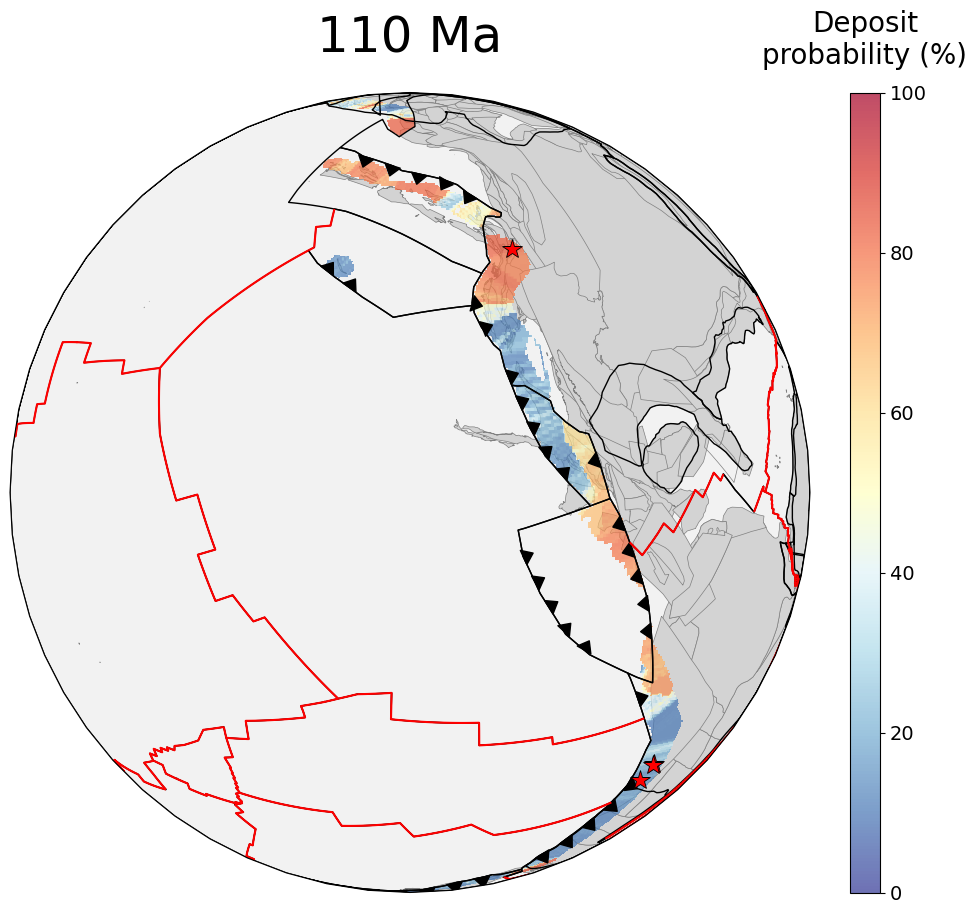

In [7]:
t = 110  # Ma

gplot.time = t
fig = plot(
    gplot=gplot,
    probabilities=os.path.join(
        probs_dir,
        f"probability_grid_{t}Ma.nc",
    ),
    positives=positives,
    projection="orthographic",
    time=t,
    central_meridian=-100,
)

### Create all plots

In [8]:
times = range(171)
output_filename = os.path.join(
    output_dir,
    "probability_animation_svm.mp4",
)

gplot_kw = dict(
    rotation_model=rotation_filenames,
    topology_features=feature_filenames,
    coastlines=coastlines_filename,
)
projection = ccrs.Orthographic(-100, 10)

with tempfile.TemporaryDirectory() as tmpdir, \
        Parallel(n_jobs=n_jobs) as parallel:
    output_filenames = [
        os.path.join(tmpdir, f"image_{t}Ma.png")
        for t in times
    ]
    parallel(
        delayed(plot)(
            gplot=gplot_kw,
            probabilities=os.path.join(
                output_dir,
                "grids",
                f"probability_grid_{t}Ma.nc",
            ),
            projection=projection,
            time=t,
            positives=positives[
                (positives["age (Ma)"] - float(t)).abs()
                <= 2.5
            ],
            output_filename=o,
            central_meridian=-100,
        )
        for t, o in zip(times, output_filenames)
    )

    with ImageSequenceClip(output_filenames[::-1], fps=5) as clip:
        clip.write_videofile(
            output_filename,
            fps=30,
            codec="mpeg4",
            bitrate="5000k",
            audio=False,
            threads=n_jobs,
            logger="bar",
            ffmpeg_params=[
                "-vf",
                "pad=ceil(iw/2)*2:ceil(ih/2)*2",
            ],
        )

/Users/chris/opt/anaconda3/envs/datamining/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Moviepy - Building video outputs/probability_animation_svm.mp4.
Moviepy - Writing video outputs/probability_animation_svm.mp4



Moviepy - Done !
Moviepy - video ready outputs/probability_animation_svm.mp4
